# Building an Intelligent EdTech Student Support Agent with LangGraph  

## Overview  
This tutorial demonstrates how to create an intelligent student support agent using **LangGraph**, a powerful tool for building complex language model workflows. The agent is designed to assist with course material inquiries, scheduling, and administrative questions, enhancing student engagement and streamlining support for educational institutions.  

## Motivation  
In today's evolving educational landscape, efficient and accurate student support is crucial. Automating the initial stages of student interaction can significantly reduce response times, improve access to information, and enhance the overall learning experience. This project showcases how advanced language models and graph-based workflows can be combined to create a sophisticated support system tailored for educational platforms.  

## Key Components  
1. **State Management**: Using TypedDict to define and manage the state of each student interaction.  
2. **Query Categorization**: Classifying student queries into categories such as **Course Material**, **Scheduling**, or **Administrative**.  
3. **Content Assistance**: Providing accurate information or resources based on the student's query.  
4. **Scheduling Support**: Helping with class schedules, reminders, and resolving conflicts.  
5. **Response Generation**: Crafting clear, helpful responses tailored to different types of queries.  
6. **Escalation Mechanism**: Automatically referring complex or unresolved queries to human support staff.  
7. **Workflow Graph**: Utilizing LangGraph to create a flexible and extensible workflow for managing student inquiries.  

## Method Details  
1. **Initialization**: Set up the environment and import necessary libraries.  
2. **State Definition**: Create a structure to hold query information, category, and generated responses.  
3. **Node Functions**: Implement functions for categorization, content retrieval, and scheduling assistance.  
4. **Graph Construction**: Use **StateGraph** to define the workflow, adding nodes and edges to represent the support process.  
5. **Conditional Routing**: Implement logic to route queries based on their type and complexity.  
6. **Workflow Compilation**: Compile the graph into an executable application.  
7. **Execution**: Process student queries through the workflow and return actionable results.  

## Conclusion  
This tutorial demonstrates the power and flexibility of **LangGraph** in creating complex, AI-driven workflows for educational platforms. By combining natural language processing capabilities with a structured graph-based approach, we've developed a student support agent that can efficiently handle a wide range of inquiries.  

This system can be further extended and customized to meet the specific needs of educational institutions, potentially integrating with existing learning management systems (LMS) and databases. The approach showcased here has broad applications beyond student support, illustrating how language models can be effectively orchestrated to solve complex, multi-step problems in various domains.


# Import Necessary Libraries

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_google_genai langchain_core

In [2]:
from typing import TypedDict, List, Dict
from langgraph.graph import END, StateGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

In [3]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [4]:
import os
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

# Define State Structure
We define a `State` class to hold the query, category, sentiment, and response for each customer interaction.

In [5]:
class State(TypedDict):
  query: str
  category: str
  sentiment: str
  response: str

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model= "gemini-1.5-flash", api_key=GEMINI_API_KEY)

# Define Node Functions
These functions represent the different stages of processing a student query.

In [11]:
def categorize(state: State) -> State:
  """Categorize the customer query into Course Material, Scheduling or Administrative."""
  prompt = ChatPromptTemplate.from_template(
      "Categorize the following customer query into of these categores: "
      "Course Material, Scheduling, Administrative. Query: {query}"
  )
  message = HumanMessage(content=prompt.format(query=state["query"]))
  category = llm.invoke([message]).content.strip()
  return {"category": category}

def analyze_sentiment(state: State) -> State:
  """Analyze the sentiment of the student query as Positive, Neutral, or Negative."""
  prompt = ChatPromptTemplate.from_template(
      "Analyze the sentiment of the following student query. "
      "Response with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
  )
  message = HumanMessage(content=prompt.format(query=state["query"]))
  sentiment = llm.invoke([message]).content.strip()
  return {"sentiment": sentiment}

def handle_course_material(state: State) -> State:
      """Provide a course material support response to the query."""
      prompt = ChatPromptTemplate.from_template(
          "Provide a course material support response to the following query. "
          "Query: {query}"
      )
      message = HumanMessage(content=prompt.format(query=state["query"]))
      response = llm.invoke([message]).content.strip()
      return {"response": response}

def handle_scheduling(state: State) -> State:
  """Provide a scheduling support response to the query."""
  prompt = ChatPromptTemplate.from_template(
      "Provide a scheduling support response to the following query."
      "Query: {query}"
  )
  message = HumanMessage(content=prompt.format(query=state["query"]))
  response = llm.invoke([message]).content.strip()
  return {"response": response}

def handle_administrative(state: State) -> State:
  """Provide an administrative support response to the query."""
  prompt = ChatPromptTemplate.from_template(
      "Provide an administrative support response to the following query."
      "Query: {query}"
  )
  message = HumanMessage(content=prompt.format(query=state["query"]))
  response = llm.invoke([message]).content.strip()
  return {"reponse": response}

def escalate(state: State) -> State:
  """Escalate the query to a human agent due to negative sentiment."""
  return {"response":"This query has been escalated to a human agent due to its negative sentiment."}

def route_query(state: State) -> str:
  """Route the query based on its sentiment and category."""
  if state["sentiment"] == "Negative":
    return "escalate"
  elif state["category"] == "Course Material":
    return "handle_course_material"
  elif state["category"] == "Scheduling":
    return "handle_scheduling"
  else:
    return "handle_administrative"


# Create and Configure the Graph
Here we set up the LangGraph, defining nodes and edges to create our EdTech student support workflow.

In [12]:
# Create the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("categorize",categorize)
workflow.add_node("analyze_sentiment",analyze_sentiment)
workflow.add_node("handle_course_material",handle_course_material)
workflow.add_node("handle_scheduling",handle_scheduling)
workflow.add_node("handle_administrative", handle_administrative)
workflow.add_node("escalate", escalate)

# Add edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges("analyze_sentiment",
                  route_query,
                  {
                      "handle_course_material":"handle_course_material",
                      "handle_scheduling":"handle_scheduling",
                      "handle_administrative":"handle_administrative",
                      "escalate":"escalate"
                  })
workflow.add_edge("handle_course_material", END)
workflow.add_edge("handle_scheduling",END)
workflow.add_edge("handle_administrative",END)
workflow.add_edge("escalate",END)

# set entry point
workflow.set_entry_point("categorize")

# compile the graph
app = workflow.compile()

# Visualize the Graph
This cell generates and displays a visual representation of our LangGraph workflow.

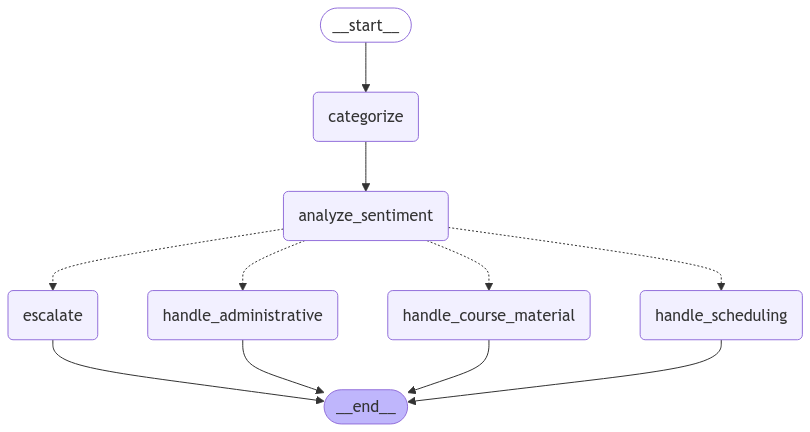

In [13]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

# Run EdTech Student Support Function
This function processes a student query through our LangGraph workflow.

In [14]:
def run_customer_support(query: str) -> Dict[str, str]:
  """Process a student query through the EdTech support workflow.

  Args:
      query (str): The customer's query

  Returns:
      Dict[str, str]: A dictionary containing the query, category, sentiment, and response.
  """
  results = app.invoke({"query": query})
  return {
      "category": results["category"],
      "sentiment": results["sentiment"],
      "response": results["response"]
  }

# Test the Sudent Support Agent
Let's test our EdTech student support agent with a sample queries for each kind of query type.

In [15]:
# escalate

query = "I am not satisfied with the management of organization?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

# handle_course_material

query = "I need the syllabus to learn Quantum physics basics"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

# handle_scheduling

query = "When will  the classes start of new semester?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

# handle_administrative

query = "I wants to enroll in another course. Am I late?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")

Query: I am not satisfied with the management of organization?
Category: Administrative
Sentiment: Negative
Response: This query has been escalated to a human agent due to its negative sentiment.


Query: I need the syllabus to learn Quantum physics basics
Category: Course Material
Sentiment: Neutral
Response: There isn't a single syllabus that universally covers "Quantum Physics Basics," as the depth and breadth of the subject vary widely depending on the intended audience and level of the course.  However, I can provide you with a potential syllabus structure and topics that would be included in a foundational course.  You can use this as a guide to find suitable learning materials, either online (e.g., MIT OpenCourseware, edX, Coursera) or in textbooks.

**Potential Syllabus Structure for Quantum Physics Basics:**

**Course Title:** Introduction to Quantum Mechanics

**Course Description:** This course provides an introduction to the fundamental concepts and principles of quantum me